<h1 style="text-align:center;">Modelling for S&P 500</h1>

### Model Training 

In [12]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

# Load the data
df = pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/Datasets/dataframe_cleaned.csv')

#Time-Series set the Data
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")

#Split the data into training and testing
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:]

#Normalised Prices
df_norm = df/df.iloc[0]*100 #Create a new variable incase we want to visualise/test/forecast with the original data
df_norm_test = df_test/df.iloc[0]*100

#Log Returns 
df_log = np.log(df / df.shift(1))
df_log_test = np.log(df_test / df_test.shift(1))

Time Series has not been set yet
It has been done now!


### Testing for Stationarity

Text(0.5, 1.0, 'S&P 500 Prices')

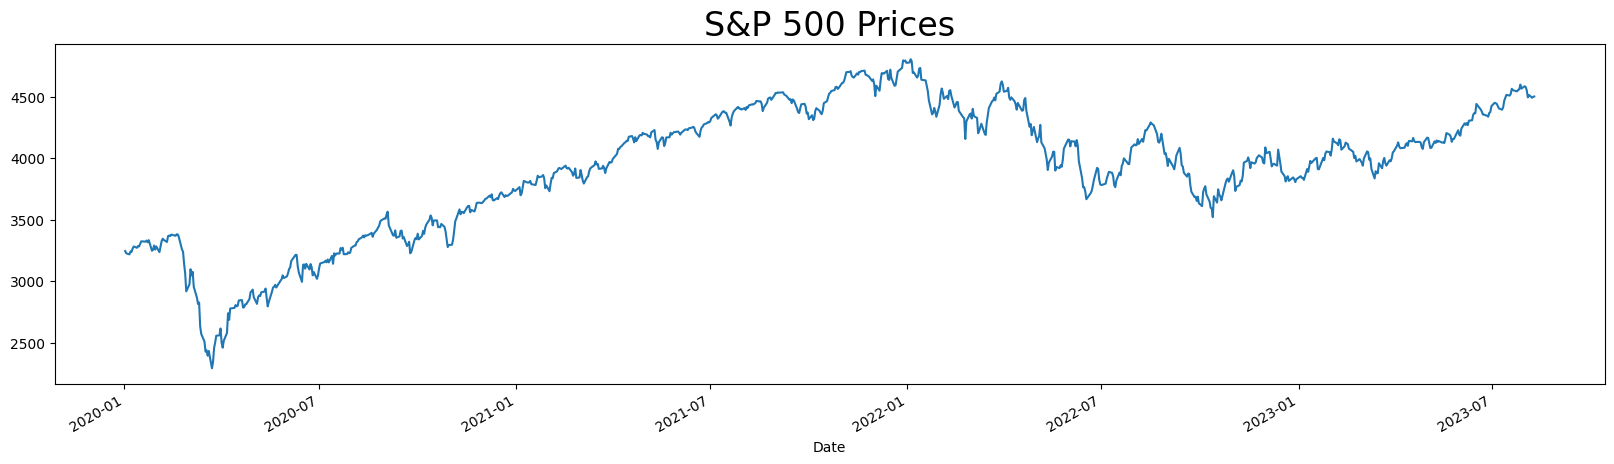

In [13]:
df.SPX.plot(figsize=(20,5))
plt.title("S&P 500 Prices", size=24) 

In [36]:
#Dickey-Fuller Test
import statsmodels.tsa.stattools as sts
adf_result1 = sts.adfuller(df.SPX)

adf_result1

(np.float64(-1.4420573341139522),
 np.float64(0.5619556138515125),
 1,
 902,
 {'1%': np.float64(-3.437620518167552),
  '5%': np.float64(-2.8647495822909477),
  '10%': np.float64(-2.568478995776815)},
 np.float64(9215.472273205383))

In [42]:
print(f'We find the p-value = {adf_result1[1]}')
#Since the p-value is greater than 0.05, we cannot reject H0, and therefore SPX is not stationary in levels form

We find the p-value = 0.5619556138515125


In [35]:
df['SPX(i1)'] = df.SPX.diff(1)
df= df.dropna()
df.head()

,SPX,NDAQ,AAPL,MSFT,NFLX,NVDA,SPX(i1)
Date,,,,,,,
2020-01-07,3241.860107,33.492839,72.592594,152.082331,336.470001,5.930140,24.310058
2020-01-08,3238.590088,33.030765,71.943766,151.710031,331.489990,5.968977,-3.270019
2020-01-09,3266.030029,32.956335,74.384158,154.487843,342.000000,6.070800,27.439941
2020-01-10,3281.810059,33.415322,75.197628,155.423335,337.130005,6.157435,15.780030
2020-01-13,3271.129883,33.182723,75.449422,154.411459,331.799988,6.165652,-10.680176


In [43]:
import statsmodels.tsa.stattools as sts
adf_result2 = sts.adfuller(df['SPX(i1)'])
print(f'We find the p-value = {adf_result2[1]}')
#Since the p-value is less than 0.05, we can reject H0, and therefore SPX is stationary in first-diff (I=1) form

We find the p-value = 0.0


### Identifying optimal AR(p) lag

(-0.15, 0.15)

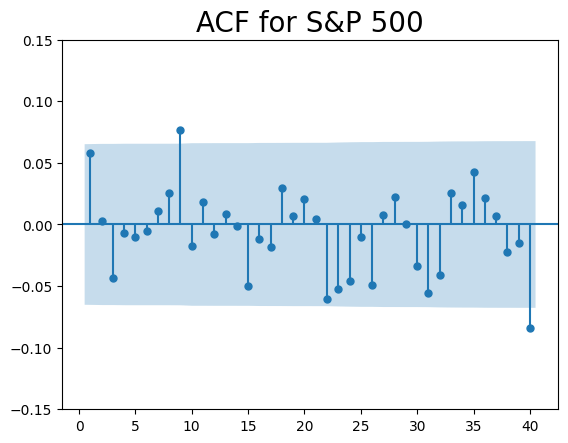

In [46]:
price_acf = sgt.plot_acf(df['SPX(i1)'], zero = False, lags = 40)
plt.title("ACF for S&P 500", size = 20)
plt.ylim(-0.15,0.15)